In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import feature_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [2]:
RANDOM_STATE = 42
DATA_EXTERNAL = "../data/external/"
DATA_PROCESSED = "../data/processed/"
DATA_INTERIM = "../data/interim/"

In [17]:
hum = pd.read_csv(DATA_PROCESSED + "humsavar_gt.tab.gz", sep="\t")
# hum["MUTANT"] = hum.MUTANT.str.rstrip()
hum.drop_duplicates(inplace=True)
hum.drop_duplicates(subset="MUTANT", keep=False, inplace=True)
protparam = pd.read_csv(DATA_INTERIM + "protparam_features.tab.gz", sep="\t")
hum = hum.merge(protparam, on="MUTANT", how="left")
cons46way = pd.read_csv("../data/interim/cons46way.csv")
hum = hum.merge(cons46way, on="dbSNP", how="left")
# hum.drop("dbSNP", axis=1, inplace=True)
hum.rename(columns={"score": "CONS46WAY"}, inplace=True)

In [27]:
hum.to_csv(DATA_PROCESSED + "humsavar_gt.csv.gz", index=False, sep="\t", compression="gzip")

In [5]:
hum = pd.read_csv(DATA_PROCESSED + "humsavar_gt.csv.gz")

In [13]:
cons46way.head()

,dbSNP,CONS46WAY
0,rs2125739,375.0
1,rs543267101,342.0
2,rs35783144,306.0
3,rs35623954,300.0
4,rs138119149,239.0


In [18]:
hum[["dbSNP", "CONS46WAY"]].head()

,dbSNP,CONS46WAY
0,NaN,NaN
1,rs17102066,396.0
2,NaN,NaN
3,rs11574115,393.0
4,rs12753610,450.0


In [11]:
hum.dbSNP.isnull().sum()

2214

In [8]:
hum.describe()

,SASA,SASA_PERCENTAGE,BFACTOR,SWITCHBILITY,AGGREGABILITY,CONSERVATION,VARIATION_ENERGY,VAR_AROMATICITY,AROMATICITY,AROMATICITY_DIFF,...,ISOELECTRIC_POINT_LOG_RATIO,VAR_GRAVY,GRAVY,GRAVY_DIFF,GRAVY_LOG_RATIO,VAR_INSTABILITY_INDEX,INSTABILITY_INDEX,INSTABILITY_INDEX_DIFF,INSTABILITY_INDEX_LOG_RATIO,score
count,7048.000000,7048.000000,7048.000000,6671.000000,5218.000000,2654.000000,7410.000000,7410.000000,7410.000000,7410.000000,...,7410.000000,7409.000000,7409.000000,7409.000000,6866.000000,7409.000000,7409.000000,7409.000000,6909.000000,3683.000000
mean,32.702895,0.153846,56.263755,0.377457,4.979459,0.330573,2.877740,0.096341,0.095370,0.019367,...,0.004007,-0.207650,-0.208688,0.234352,NaN,37.185198,41.025746,13.432278,0.072018,393.699158
std,39.396009,0.178437,70.326824,0.878123,17.649479,0.190226,4.876730,0.079048,0.080453,0.026049,...,0.153169,0.777717,0.787648,0.172299,NaN,31.802558,32.787401,12.816648,0.714295,96.341700
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,-8.746030,0.000000,0.000000,0.000000,...,-0.683566,-2.740000,-2.875000,0.000000,-inf,-47.066667,-38.193750,0.001250,-7.221495,209.000000
25%,0.725000,0.000000,20.148125,0.000000,0.000000,0.250000,0.233566,0.066667,0.062500,0.004167,...,-0.026302,-0.726667,-0.737500,0.094167,-0.225511,14.306667,16.712500,3.830000,-0.181444,328.000000
50%,16.116500,0.080000,37.798750,0.007580,0.000000,0.300000,1.464775,0.066667,0.062500,0.008333,...,0.000000,-0.233333,-0.237500,0.202917,0.005326,33.613333,37.412500,9.607500,0.024517,389.000000
75%,54.097000,0.270000,61.146250,0.261000,0.152000,0.360000,3.745210,0.133333,0.125000,0.020833,...,0.044765,0.286667,0.281250,0.340833,0.240843,56.746667,61.400000,19.267083,0.336641,445.000000
max,246.410000,0.750000,755.610000,8.720000,100.000000,4.770000,57.513400,0.466667,0.500000,0.222222,...,0.761106,3.386667,3.275000,1.272222,inf,183.067333,195.775000,105.460417,4.830811,864.000000


In [32]:
hum.replace([np.inf,-np.inf], np.nan, inplace=True)

In [33]:
model_dict = {
    'lr':{'pipe':('lr', LogisticRegression(random_state=RANDOM_STATE)),
          'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
          'name':'LogisticRegression'
    },
    'rf':{'pipe':('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
          'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2]}],
          'name':'Random Forest'
    },
    'svc':{'pipe':('svc', SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True)),
           'params':[{'svc__C':[0.001, 0.01, 0.1, 1, 10], 'svc__gamma':[0.001, 0.01, 0.1, 1]}],
           'name': 'Support Vector Classifier'
    }
}

In [34]:
dataset = hum.drop(['3DID', 'PDB'], 1) \
    .replace({"ACTIVE_SITE": {"BINDING": 1, np.nan: 0}}) \
    .set_index("MUTANT")

unclassified_index = dataset[dataset.TYPE == "Unclassified"].index
dataset_disease_index = dataset[dataset.TYPE == "Disease"].index
dataset_poly_index = dataset[dataset.TYPE == "Polymorphism"].index

#### 50-50% en el set de entrenamiento y 60-40% en set de evaluación respetando humsavar

In [35]:
for i in range(20):
    train = pd.concat([
        dataset.loc[dataset_disease_index].sample(n=1500, random_state=i),
        dataset.loc[dataset_poly_index].sample(n=1500, random_state=i)
    ])

    test = pd.concat([
        dataset.loc[dataset_disease_index.difference(train.index)].sample(n=320, random_state=i),
        dataset.loc[dataset_poly_index.difference(train.index)].sample(n=483, random_state=i)
    ])
    train.to_csv(DATA_PROCESSED + "train_test_sets/train_{}.tab.csv".format(i), sep="\t", index=True, index_label="MUTANT")
    test.to_csv(DATA_PROCESSED + "train_test_sets/test_{}.tab.csv".format(i), sep="\t", index=True, index_label="MUTANT")

#### Random Forest

In [36]:
algorithm = 'rf'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), 
                  model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=3, n_jobs=2, scoring='roc_auc', verbose=1, refit=True)

In [37]:
train_scores = []
test_scores = []
for i in range(20):
    train = pd.read_csv(DATA_PROCESSED + "train_test_sets/train_{}.tab.csv".format(i), sep="\t", index_col="MUTANT")
    test = pd.read_csv(DATA_PROCESSED + "train_test_sets/test_{}.tab.csv".format(i), sep="\t", index_col="MUTANT")
    X_train = train.drop("TYPE", 1)
    y_train = train.TYPE
    X_test = test.drop("TYPE", 1)
    y_test = test.TYPE
    le = LabelEncoder().fit(y_train)
    gs.fit(X_train, le.transform(y_train))
#     print("Score train ({}): {}".format(i, gs.best_score_))
    rf = gs.best_estimator_
    y_pred = rf.predict(X_test)
    test_score = roc_auc_score(le.transform(y_test), y_pred)
#     print("Score test ({}): {}".format(i, score))
    test_scores.append(test_score)
    train_scores.append(gs.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.5s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.7s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    9.4s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    9.2s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  78 out of  81 | elapsed:   10.1s remaining:    0.4s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   10.6s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   10.1s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.6s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.9s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.9s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  78 out of  81 | elapsed:   11.2s remaining:    0.4s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   12.1s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   11.4s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    9.7s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  78 out of  81 | elapsed:    9.7s remaining:    0.4s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    9.7s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    9.3s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   10.1s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.8s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.4s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.8s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    9.8s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    9.0s finished


In [32]:
print("MEAN: ", np.mean(test_scores))
print("STDDEV: ", np.std(test_scores))

MEAN:  0.686163625776
STDDEV:  0.0153715857644


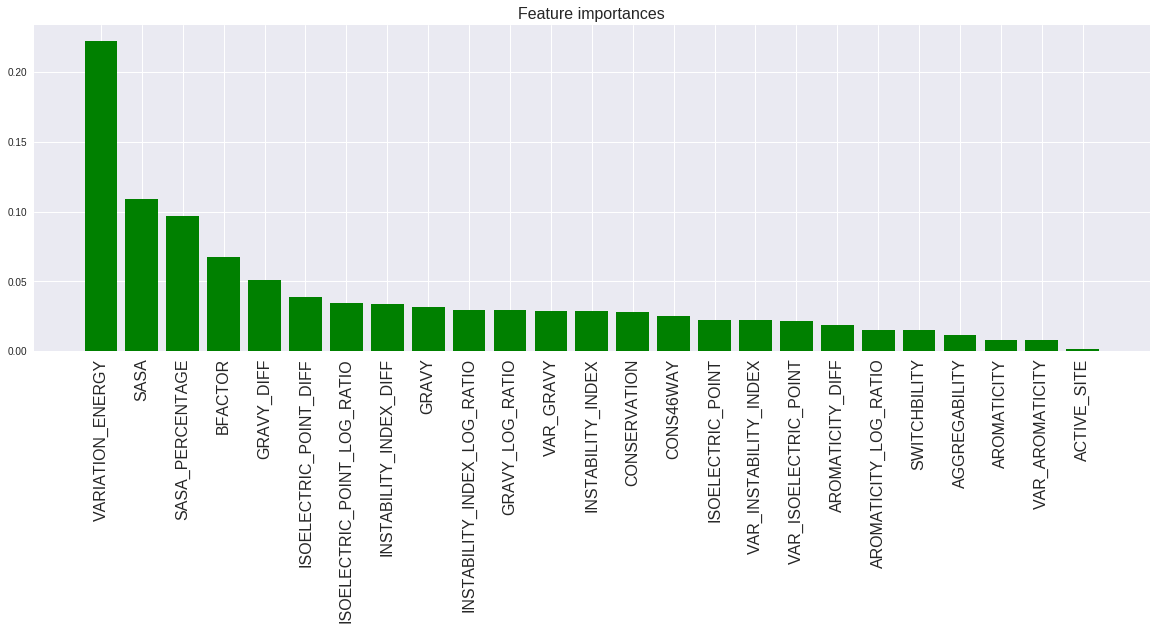

In [39]:
importances = [(X_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
figsize(20,6)
plt.title("Feature importances", fontsize=16)
plt.bar(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xticks(range(len(importances)), [x for x, y in importances], rotation='vertical', fontsize=16)
# plt.xlim([0, range(len(importances))])
plt.show()

#### Y los unclassified?

In [40]:
pd.Series(le.inverse_transform(rf.predict(dataset.loc[unclassified_index].drop("TYPE", 1)))).value_counts()

Polymorphism    327
Disease         277
dtype: int64

#### Support Vector Classifier

In [41]:
algorithm = 'svc'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), 
                  ('scale', RobustScaler()), 
                  model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=3, n_jobs=2, scoring='roc_auc', verbose=1, refit=True)

In [44]:
train_scores = []
test_scores = []
for i in range(20):
    train = pd.read_csv(DATA_PROCESSED + "train_test_sets/train_{}.tab.csv".format(i), sep="\t", index_col="MUTANT")
    test = pd.read_csv(DATA_PROCESSED + "train_test_sets/test_{}.tab.csv".format(i), sep="\t", index_col="MUTANT")
    X_train = train.drop("TYPE", 1)
    y_train = train.TYPE
    X_test = test.drop("TYPE", 1)
    y_test = test.TYPE
    le = LabelEncoder().fit(y_train)
    gs.fit(X_train, le.transform(y_train))
#     print("Score train ({}): {}".format(i, gs.best_score_))
    svc = gs.best_estimator_
    y_pred = svc.predict(X_test)
    score = roc_auc_score(le.transform(y_test), y_pred)
#     print("Score test ({}): {}".format(i, score))
    train_scores.append(gs.best_score_)
    test_scores.append(score)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   45.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   59.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   44.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   58.4s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   49.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.1min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   49.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.1min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   48.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.1min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   47.1s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.0min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   45.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.0min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   44.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   59.3s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   45.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   60.0s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   44.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   59.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   48.3s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.1min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   45.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   58.6s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   43.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   56.5s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   43.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   56.6s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   43.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   57.2s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   43.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   56.9s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   42.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   56.3s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   51.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.1min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   47.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.0min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   47.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.0min finished


In [46]:
print("MEAN: ", np.mean(train_scores))
print("STDDEV: ", np.std(train_scores))

MEAN:  0.715766533333
STDDEV:  0.0063637597678


In [45]:
print("MEAN: ", np.mean(test_scores))
print("STDDEV: ", np.std(test_scores))

MEAN:  0.667607078157
STDDEV:  0.0184516735429


In [62]:
y_proba = pd.DataFrame(svc.predict_proba(X_test))[0]

In [64]:
svc_results = pd.DataFrame({"y_pred": y_pred, "y_true": le.transform(y_test), "score": y_proba})

In [65]:
svc_results.to_csv("../results/svc_results.csv", index=False)